In [14]:
import torch
import torch.nn as nn
from models import GridMLMMelHarm
from GridMLM_tokenizers import CSGridMLMTokenizer
from data_utils import CSGridMLMDataset, CSGridMLM_collate_fn
from torch.utils.data import DataLoader
from train_utils import apply_masking
from generate_utils import generate_files_with_greedy, load_model
import matplotlib.pyplot as plt

In [15]:
tokenizer = CSGridMLMTokenizer(fixed_length=256, intertwine_bar_info=True, trim_start=False)
val_dir = '/media/maindisk/data/hooktheory_midi_hr/CA_test'

In [16]:
curriculum_type = 'random'
# curriculum_type = 'base2'
subfolder = 'bar/CA'
device_name = 'cuda:2'
model = load_model(
    curriculum_type=curriculum_type,
    subfolder=subfolder,
    device_name=device_name,
    tokenizer=tokenizer,
    conditioning_dim=8,
    pianoroll_dim=tokenizer.pianoroll_dim,
)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

26200547


In [18]:
import os
data_files = []
for dirpath, _, filenames in os.walk(val_dir):
    for file in filenames:
        if file.endswith('.xml') or file.endswith('.mxl') or file.endswith('.musicxml') \
            or file.endswith('.mid') or file.endswith('.midi'):
            full_path = os.path.join(dirpath, file)
            data_files.append(full_path)
print(len(data_files))

758


In [ ]:
val_idx = 300
# TODO: check out 200, it has a problem rendering to file

input_f = data_files[val_idx]
# input_f = 'example_inputs/test_midi_constraints.mid'

mxl_folder = 'examples_musicXML/' + subfolder + '/' + curriculum_type + '/' + '/'
midi_folder = 'examples_MIDI/' + subfolder + '/' + curriculum_type + '/' + '/'
os.makedirs(mxl_folder, exist_ok=True)
os.makedirs(midi_folder, exist_ok=True)

gen_harm, real_harm, gen_score, real_score, avg_diffs = generate_files_with_greedy(
    model=model,
    tokenizer=tokenizer,
    input_f=input_f,
    mxl_folder=mxl_folder,
    midi_folder=midi_folder,
    name_suffix='bar_test',
    intertwine_bar_info=True,
    trim_start=False,
    use_constraints=False,
    condition='h_density_complexity'
)

/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/music21/base.py:559: UserWarning: Setting an ID that could be mistaken for a memory location is discouraged: got 138142278695680
  warnings.warn(msg)


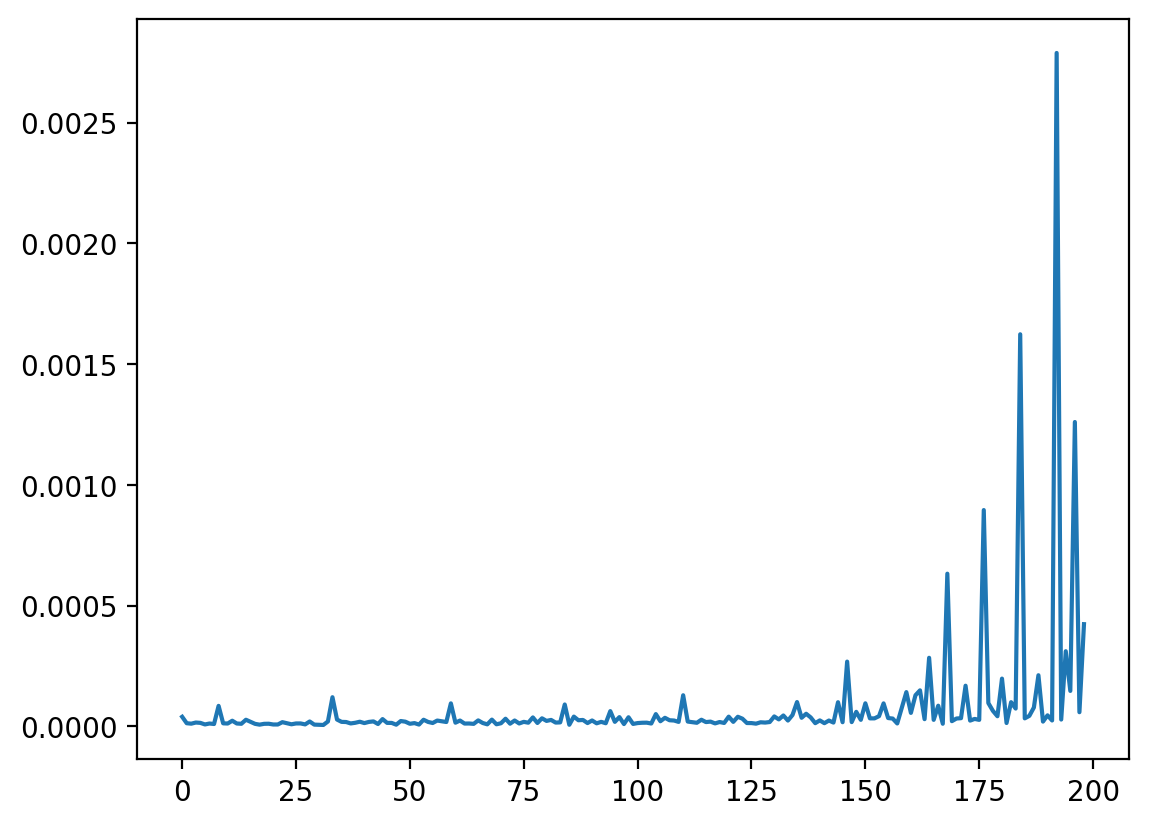

In [20]:
plt.plot(avg_diffs)